In [24]:
import torch
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torchvision.io import decode_image
from torchvision.io import ImageReadMode
from einops import rearrange
from segdac.networks.image_segmentation_models.grounded_efficientvit_sam import (
    GroundedEfficientVitSam,
)
from segdac.networks.image_segmentation_models.grounded_efficientvit_sam import get_image_covered_by_predicted_masks
from segdac_dev.visualization.segments import (
    draw_segments_contours,
    draw_rgb_segments_grid,
)

seed = 123

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

Loaded image :torch.Size([3, 512, 512]) cuda:0


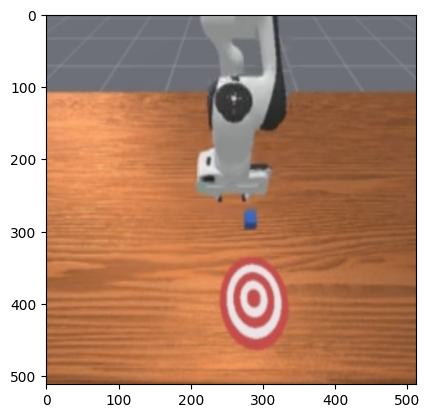

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

image_path = "images/push_cube.png"

image = decode_image(image_path, mode=ImageReadMode.RGB).to(device)
image_size = 512

env_transforms = v2.Compose(
    [
        v2.Resize(size=(image_size, image_size)),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)
image = env_transforms(image)
print(f"Loaded image :{image.shape} {image.device}")

fig, ax = plt.subplots()
ax.imshow(rearrange(image, "c h w ->h w c").cpu().numpy())

Loaded image :torch.Size([3, 512, 512]) cuda:0


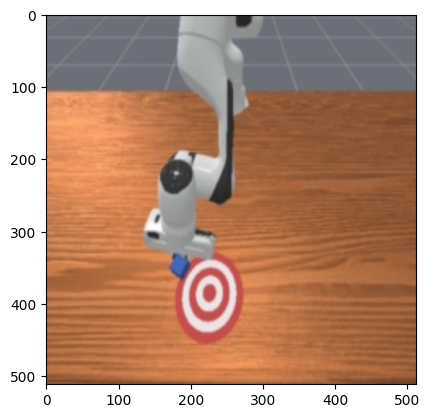

In [58]:
image_path2 = "images/push_cube_2.png"
image2 = decode_image(image_path2, mode=ImageReadMode.RGB).to(device)
image2 = env_transforms(image2)
print(f"Loaded image :{image2.shape} {image2.device}")

fig, ax = plt.subplots()
ax.imshow(rearrange(image2, "c h w ->h w c").cpu().numpy())

In [208]:
# tags = ["cartpole", "pole"]
tags = ["robot", "gripper", "small box", "target"]
segmenter = GroundedEfficientVitSam(
    device=device,
    grounding_text_tags=tags,
    object_detector_weights_path="../weights/yolov8s-worldv2.pt",
    object_detection_confidence_threshold=0.0001,
    object_detection_iou_threshold=0.01,
    segmenter_model_name="efficientvit-sam-l0",
    segmenter_weights_path="../weights/efficientvit_sam_l0.pt",
    masks_post_process_kernel_size=9,
)

In [209]:
pred_imgs = torch.stack([image, image2])
pred_imgs.shape, pred_imgs.dtype, pred_imgs.device, pred_imgs.min(), pred_imgs.max()

(torch.Size([2, 3, 512, 512]),
 torch.float32,
 device(type='cuda', index=0),
 tensor(0.0706, device='cuda:0'),
 tensor(1., device='cuda:0'))

In [210]:
torch.cuda.synchronize()
a = time.perf_counter()
predictions = segmenter.segment(pred_imgs)
torch.cuda.synchronize()
b = time.perf_counter()
b - a

0.22677692770957947

In [211]:
torch.cuda.synchronize()
a = time.perf_counter()
predictions = segmenter.segment(pred_imgs)
torch.cuda.synchronize()
b = time.perf_counter()
b - a

0.06233830004930496

In [212]:
predictions

TensorDict(
    fields={
        absolute_segment_ids: Tensor(shape=torch.Size([7]), device=cuda:0, dtype=torch.int64, is_shared=True),
        binary_masks: Tensor(shape=torch.Size([7, 1, 512, 512]), device=cuda:0, dtype=torch.uint8, is_shared=True),
        classes: Tensor(shape=torch.Size([7]), device=cuda:0, dtype=torch.float32, is_shared=True),
        coords: TensorDict(
            fields={
                masks_absolute_bboxes: Tensor(shape=torch.Size([7, 4]), device=cuda:0, dtype=torch.int64, is_shared=True),
                masks_normalized_bboxes: Tensor(shape=torch.Size([7, 4]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([7]),
            device=cuda:0,
            is_shared=True),
        image_ids: Tensor(shape=torch.Size([7]), device=cuda:0, dtype=torch.int64, is_shared=True),
        relative_segment_ids: Tensor(shape=torch.Size([7]), device=cuda:0, dtype=torch.int64, is_shared=True),
        rgb_segments: Tensor(shape=torch.

In [213]:
predictions['image_ids'], predictions['absolute_segment_ids'], predictions['relative_segment_ids']

(tensor([0, 0, 0, 0, 1, 1, 1], device='cuda:0'),
 tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0'),
 tensor([0, 1, 2, 3, 0, 1, 2], device='cuda:0'))

In [214]:
a = time.perf_counter()
images_from_predicted_masks = get_image_covered_by_predicted_masks(
    original_images=(pred_imgs * 255.0).to(torch.uint8), segments_data=predictions
)
b = time.perf_counter()
print(b - a)

0.0006942301988601685


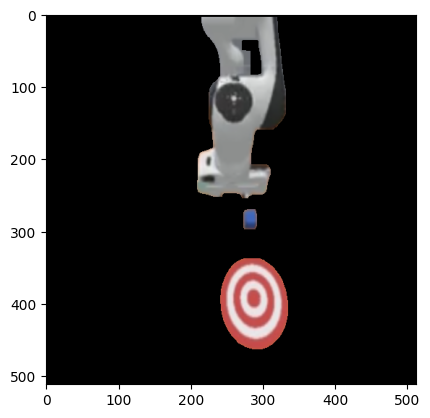

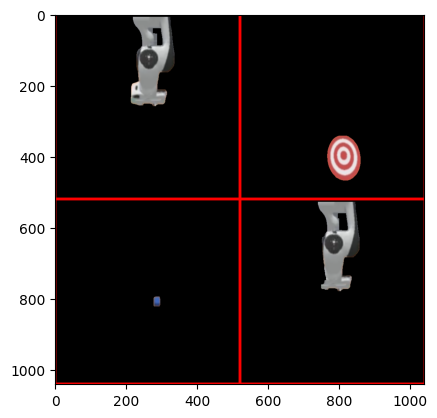

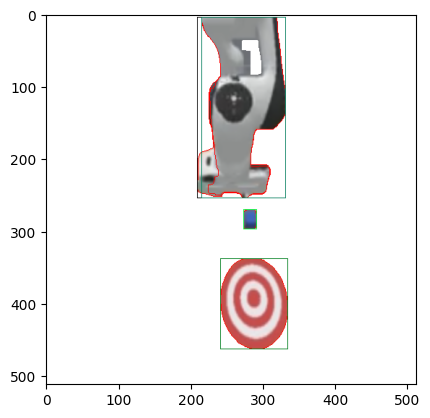

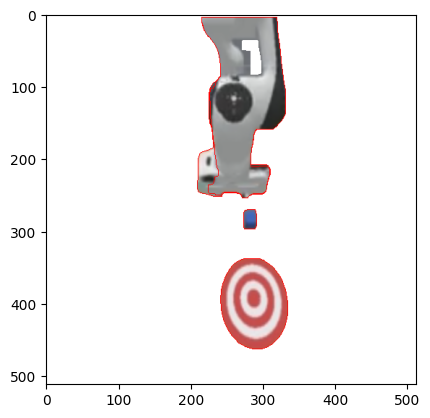

In [215]:
plt.imshow(rearrange(images_from_predicted_masks[0].cpu().numpy(), "c h w -> h w c"))
plt.show()
plt.imshow(draw_rgb_segments_grid(predictions, image_id=0, figsize=(4, 4), show=False))
plt.show()
plt.imshow(draw_segments_contours(predictions=predictions, image_id=0, draw_bboxes=True))
plt.show()
plt.imshow(draw_segments_contours(predictions=predictions, image_id=0, draw_bboxes=False))
plt.show()

# Uncomment cell below if you have more than 1 image in pred_imgs

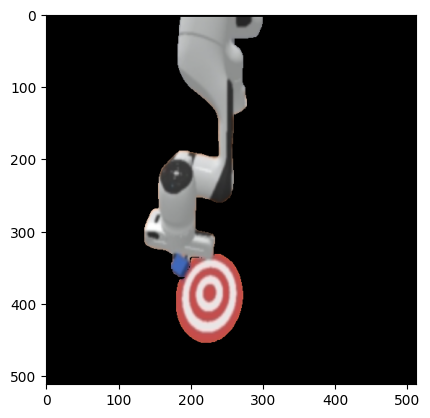

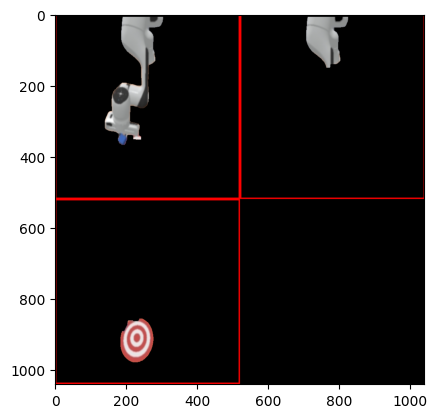

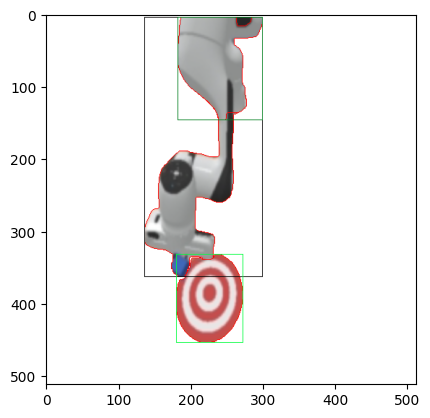

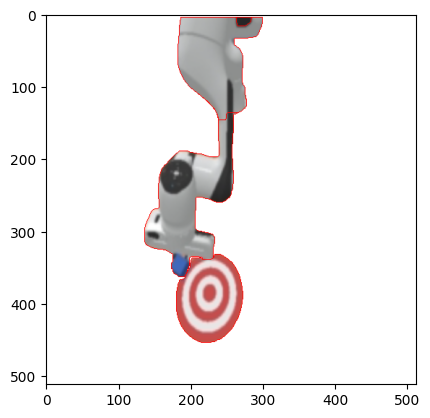

In [216]:
plt.imshow(rearrange(images_from_predicted_masks[1].cpu().numpy(), "c h w -> h w c"))
plt.show()
plt.imshow(draw_rgb_segments_grid(predictions, image_id=1, figsize=(4, 4), show=False))
plt.show()
plt.imshow(draw_segments_contours(predictions=predictions, image_id=1, draw_bboxes=True))
plt.show()
plt.imshow(draw_segments_contours(predictions=predictions, image_id=1, draw_bboxes=False))
plt.show()